**This notebook is to parse out pdb file and bin residues on the surface of the protein**

In [1]:
#import the necessary modules 
%matplotlib inline 
import numpy as np 
import matplotlib.pylab as plt 
import pandas as pd 
import scipy
import sklearn
import itertools 
from itertools import cycle 
import os.path as op
import timeit 


# These imports are for creating the percent occupancy heat map 
import plotly
import plotly.plotly as py
import plotly.graph_objs as go

### create occupancy file using mdtraj and other tools from the .gro and .xtc file... Output txt file after splitting trajectory

### Figure out how to setup ipyparallel for using multiple nodes 

In [ ]:
import ipyparallel as ipp

## connect to the client
ipyclient = ipp.Client(profile="MPI32")

## print how many engines are connected
print(len(ipyclient), 'cores')


### Below makes a plot with number of surface residues 

In [2]:
# Read in data from the oputput of wrapper.sh, where the frame count is given for each BSA residue that was within 
# 4 angstroms of PLGA trimer 
wat_data = pd.read_csv('occ_BSA1ns.txt', sep=" ", header=None, usecols=None ,index_col=None)
wat_data.columns = ["BSA_res_no","No. of frames"]
wat_data.head()

,BSA_res_no,No. of frames
0,1,1002
1,2,1002
2,3,1002
3,4,1002
4,5,1002


In [3]:
a_a = ["GLY","ALA","VAL","LEU","ILE","MET","PHE","TRP","PRO","SER","THR","CYS","TYR","ASN","GLN","ASP"
               ,"GLU","LYS","ARG","HIS"]

In [4]:
import multiprocessing as m_proc
m_proc.cpu_count()

16

In [5]:
# Isolate each residue of bsa from pdb file(not in list method, 2nd draft, 70.72s run time) 

#start_time = timeit.default_timer()

red_bsa = []
for j in range(len(wat_data["BSA_res_no"])):
    for i in range(len(a_a)):
        st_r = str(" "+a_a[i]+"     "+str(j+1)+" ")
        st_r1 = str(" "+a_a[i]+"    "+str(j+1)+" ")
        st_r2 = str(" "+a_a[i]+"   "+str(j+1)+" ")
        for line in open("../BSA.pdb",'r'):
            if st_r in line:
                # Since the list is empty, this if statement makes sure the first 10 residues are added properly 
                if len(red_bsa) == 0:
                    if st_r not in red_bsa:
                        l = line.splitlines()
                        red_bsa.append(l[0][16:27])
                elif len(red_bsa) != 0:
                    hj = len(red_bsa) - 1
                    if st_r not in red_bsa[hj]:
                        lb = line.splitlines()
                        red_bsa.append(lb[0][16:27])
            elif st_r1 in line:
                lj = len(red_bsa) - 1
                if st_r1 not in red_bsa[lj]:
                    b = line.splitlines()
                    red_bsa.append(b[0][16:27])     
            elif st_r2 in line:
                kj = len(red_bsa) - 1
                if st_r2 not in red_bsa[kj]:
                    r2 = line.splitlines()
                    red_bsa.append(r2[0][16:27]) 
                    
#timeit.default_timer() - start_time
#rb = [row[1:4] for row in red_bsa]

In [ ]:
# Isolate each residue of bsa from pdb file(memory intensive code, first draft, 73.52s to run through pdb file)

#s_time = timeit.default_timer()

red_bsa_mem = []
for j in range(len(wat_data["BSA_res_no"])):
    for i in range(len(a_a)):
        st_r = str(" "+a_a[i]+"     "+str(j+1)+" ")
        st_r1 = str(" "+a_a[i]+"    "+str(j+1)+" ")
        st_r2 = str(" "+a_a[i]+"   "+str(j+1)+" ")
        for line in open("../BSA.pdb",'r'):
            if st_r in line: 
                l = line.split()
                if len(l) == 10:
                    red_bsa_mem.append(l[3:5])
            elif st_r1 in line:
                b = line.split()
                if len(b) == 10:
                    red_bsa_mem.append(b[3:5])
            elif st_r2 in line:
                r2 = line.split()
                if len(r2) == 10:
                    red_bsa_mem.append(r2[3:5])
        res_l = len(red_bsa_mem)
        del red_bsa_mem[j+1:j+res_l]
        
#timeit.default_timer() - s_time

#rb = [row[0] for row in red_bsa]

In [6]:
# This cell shows the frame count of each BSA residue 
rb = [row[1:4] for row in red_bsa] 
pand_rb = pd.Series(rb, index=None)
wat_data['BSA_res_des_order'] = pand_rb
wat_data = wat_data[["BSA_res_no",'BSA_res_des_order',"No. of frames"]]
#wat_data

### Now onto to the counting of surface residues from occ.txt

In [7]:
#Get the count of bsa residues that have 1001 or 1002 frames ( I ran a 1 ns NPT simulation of 1 BSA in water )

#aa_count = pd.DataFrame(data=a_a)
c_list = []

for i in range(len(a_a)):
    count = 0
    for index, row in wat_data.iterrows():
        if row['BSA_res_des_order'] == a_a[i]:
            if row['No. of frames'] == 1001: 
                count += 1
                #c_list.append(str(str(a_a[i])+"  "+str(row['No. of frames']))) 
            elif row['No. of frames'] == 1002:
                count += 1
                #c_list.append(str(str(a_a[i])+"  "+str(row['No. of frames'])))
    c_list.append(str(str(a_a[i])+"  "+str(count)))

In [8]:
#aromatic_res = ['PHE', 'TRP', 'TYR', 'HIS']
hydrophobic_res = ['ALA', 'ILE', 'LEU', 'VAL', 'GLY', 'PRO','PHE', 'TRP','MET']
polar_res = ['ASN', 'CYS', 'GLN', 'SER', 'THR','TYR']
neg_res = ['ASP', 'GLU']
pos_res = ['ARG', 'HIS', 'LYS']

all_res = [pos_res, neg_res, polar_res, hydrophobic_res]
#Change order of residues before making the bar graph
# (!) Positively charged
# (2) Negatively charged
# (3) Polar residues 
# (4) Hydrophobic residues 


# This chunk of code sorts the counts of each AA that have 1001 or 1002 frame count based on the AA order in all_res
arr_list = []

for row in all_res:
    for i in range(len(c_list)):
        for j in range(len(row)):
            if row[j] == c_list[i][0:3]:
                arr_list.append(c_list[i])

#all_res
#arr_list

#This chunk of code splits the list arr_list to makes the AA: count of 1001 or 1002 frames data plottable 
f_list = []
fn_list = []
for i in range(len(arr_list)):
    f_list.append(arr_list[i][0:3])
    fn_list.append(int(arr_list[i][5:7]))

# Put the AA count in a pandas dataframe 
aa_count = pd.DataFrame(data=f_list, index=None, columns=['Amino_acids'])
new_lf = pd.Series(data=fn_list, index=None)
aa_count['No. of surf. res.'] = new_lf
#aa_count.tail()


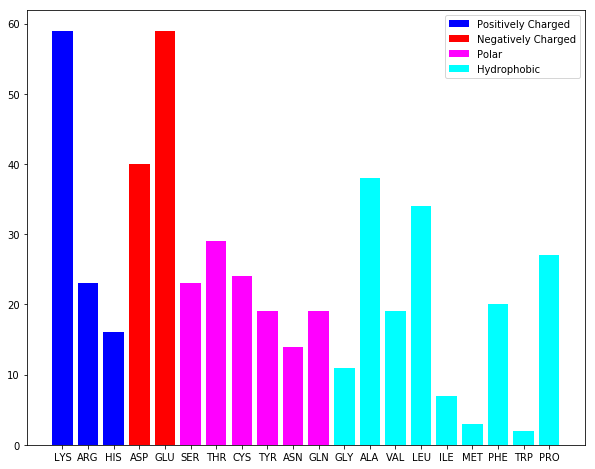

In [35]:
#plotting 
#Change order of residues before making the bar graph
# (!) Positively charged
# (2) Negatively charged
# (3) Polar residues 
# (4) Hydrophobic residues 
x = np.arange(20)
leg = ['Positively Charged', 'Negatively Charged', 'Polar', 'Hydrophobic']
plt.figure(figsize=(10,8))
plt.bar(x[0:3], aa_count['No. of surf. res.'][0:3], color='blue')
plt.bar(x[3:5], aa_count['No. of surf. res.'][3:5], color='red')
plt.bar(x[5:11], aa_count['No. of surf. res.'][5:11], color='magenta')
plt.bar(x[11:20], aa_count['No. of surf. res.'][11:20], color='cyan')
plt.xticks(x,aa_count['Amino_acids'])
plt.legend(leg)

In [10]:
aa_count

,Amino_acids,No. of surf. res.
0,LYS,59
1,ARG,23
2,HIS,16
3,ASP,40
4,GLU,59
5,SER,23
6,THR,29
7,CYS,24
8,TYR,19
9,ASN,14


In [11]:
aa_count['No. of surf. res.'].sum()

486

### Now to calculate the fraction of contacts for each type amino acid group

In [12]:
# Read in data from the oputput of wrapper.sh, where the frame count is given for each BSA residue that was within 
# 4 angstroms of PLGA trimer 
pl_25ns_data = pd.read_csv('occ_25ns_p1.txt', sep=" ", header=None, usecols=None ,index_col=None)
pl_25ns_data.columns = ['BSA_res_no','No_of_frames(PLGA trimer)']
#pand_rb = pd.Series(rb, index=None)
pl_25ns_data['BSA_res_des_order'] = pand_rb
pl_25ns_data = pl_25ns_data[["BSA_res_no","BSA_res_des_order","No_of_frames(PLGA trimer)"]]
pl_25ns_data.head()

## Use this occupancy file to organize surface amino acids similar to above code 

,BSA_res_no,BSA_res_des_order,No_of_frames(PLGA trimer)
0,1,ASP,704
1,2,THR,2154
2,3,HIS,2502
3,4,LYS,2502
4,5,SER,2500


In [13]:
apl_list = []

# Some residues don't have any contact with PLGA trimers within 25 ns, put residues that do have contact with BSA in a separate list
for index, r_pl in pl_25ns_data.iterrows():
    if r_pl['No_of_frames(PLGA trimer)'] != 0:
        apl_list.append(r_pl['BSA_res_des_order'])

        
# This chunk of code gets an AA count from the above list, in order to get a total number of residues that contact BSA
cpl_l = []

for index, r_a in aa_count.iterrows():
    count = 0
    for i in range(len(apl_list)):
        if apl_list[i] == r_a['Amino_acids']:
            count += 1
    cpl_l.append(count)      
        
aa_count['PLGA_trimer_25ns_SR'] = cpl_l
aa_count

,Amino_acids,No. of surf. res.,PLGA_trimer_25ns_SR
0,LYS,59,53
1,ARG,23,16
2,HIS,16,16
3,ASP,40,31
4,GLU,59,50
5,SER,23,15
6,THR,29,29
7,CYS,24,20
8,TYR,19,14
9,ASN,14,10


In [14]:
# This gives the total number of residues that are within 4 angstroms of PLGA trimers within a 25 ns block. 
# All other residues were not within 4 A over the course of the 25 ns trajectory block 
aa_count['PLGA_trimer_25ns_SR'].sum()

398

In [15]:
# This gives the total number of residues that are within 4 angstroms of a water molecule within a 1 ns trajectory block
aa_count['No. of surf. res.'].sum()

486

In [16]:
# Grouping of residues in Smith et al  
aromatic_res = ['PHE', 'TRP', 'TYR', 'HIS']
hydrophobic_res = ['ALA', 'ILE', 'LEU', 'VAL', 'GLY', 'PRO','PHE', 'TRP','MET']
polar_res = ['ASN', 'CYS', 'GLN', 'SER', 'THR','TYR']
neg_res = ['ASP', 'GLU']
pos_res = ['ARG', 'HIS', 'LYS']

frac_res = [aromatic_res, hydrophobic_res, neg_res, polar_res, pos_res]

# For each amino acid type in frac_res, this code chunk saves the frame count in a list and sums them together to 
# to get a total frame count within the 25 ns trajectory for each AA group in frac_res
co_grpaa = []

for row in frac_res:
    fr_list = []
    for j in range(len(row)):
        for index, r_pl in pl_25ns_data.iterrows():
            if row[j] == r_pl["BSA_res_des_order"]:
                fr_list.append(r_pl["No_of_frames(PLGA trimer)"])
    co_grpaa.append(sum(fr_list))

    
# For each AA type in frac_res, this code chunk saves the count for each AA within 4 Angstroms of a PLGA trimer 
# in a list based on the order in frac_res, then sums the counts to get a total number of AA for each AA type 
# that was within 4 Angstroms of a PLGA trimer 
tp_cnt = []
    
for row in frac_res:
    nw_l = []
    for j in range(len(row)):
        for index, r_aa in aa_count.iterrows(): 
            if row[j] == r_aa["Amino_acids"]:
                nw_l.append(r_aa['PLGA_trimer_25ns_SR'])
    tp_cnt.append(sum(nw_l))
    

# This data has not been normalized by each amino acid type 
res_aa = {'aa_group_type': ["Aromatic", "Hydrophobic", "Negative", "Polar", "Positive"]}
p25ns_NOT = pd.DataFrame(data=res_aa)
p25ns_NOT['frame_count'] = co_grpaa 
p25ns_NOT['type_of_contact'] = tp_cnt
p25ns_NOT

,aa_group_type,frame_count,type_of_contact
0,Aromatic,62307,49
1,Hydrophobic,143865,134
2,Negative,73533,81
3,Polar,93455,98
4,Positive,80889,85


In [17]:
# Now to calculate the normalized data 

# Total number of surface residues contacted by water in a only BSA/water simulation 
#b_sum = aa_count['No. of surf. res.'].sum()


# In Smith et al., the contacts data has been normalized by the protein
# surface fraction of each amino acid residue type contacted by each 
# polymer surrogate over the portion of the simulation trajectories 

# Get the total count of AA that are within 4 A of a PLGA trimer 
b_sum = p25ns_NOT['type_of_contact'].sum()


# The code chunk normalized the frame count of each AA group type by the protein surface fraction 
# of each amino acid type contacted by a polymer surrogate. It is possible that some amino acids 
# are in contact with more than 1 oligomer. This fractional contact does not account for that. 
norm_list = []

for index, row in p25ns_NOT.iterrows():
    norm_list.append(int(row["frame_count"]/(row["type_of_contact"]/b_sum)))
    
p25ns_NOT["contacts_NORM"] = norm_list 
p25ns_NOT.loc[5] = ["Sum", p25ns_NOT['frame_count'].sum(), p25ns_NOT['type_of_contact'].sum(), p25ns_NOT['contacts_NORM'].sum()]
p25ns_NOT

,aa_group_type,frame_count,type_of_contact,contacts_NORM
0,Aromatic,62307,49,568392
1,Hydrophobic,143865,134,479907
2,Negative,73533,81,405793
3,Polar,93455,98,426269
4,Positive,80889,85,425380
5,Sum,454049,447,2305741


In [18]:
# This conde chunk calculates the fractional contact based on the normalized frame count 
cont_l = []
f_sum = p25ns_NOT['contacts_NORM'].loc[5]

for index, row in p25ns_NOT.iterrows():
    cont_l.append(row['contacts_NORM']/f_sum)
    
p25ns_NOT['frac_cont_norm'] = cont_l
p25ns_NOT

,aa_group_type,frame_count,type_of_contact,contacts_NORM,frac_cont_norm
0,Aromatic,62307,49,568392,0.246512
1,Hydrophobic,143865,134,479907,0.208136
2,Negative,73533,81,405793,0.175992
3,Polar,93455,98,426269,0.184873
4,Positive,80889,85,425380,0.184487
5,Sum,454049,447,2305741,1.000000


In [ ]:
# This code plots the fractional contacts in a bar plot 
x = np.arange(5)
plt.figure(figsize=(10,10))
plt.bar(x, p25ns_NOT['frac_cont_norm'].loc[0:4])
plt.xticks(x,p25ns_NOT['aa_group_type'].loc[0:4])

### Now use MD Analysis to calculate no. of frames a PLGA residue was with 4 Angstroms of BSA

In [19]:
# Import MDAnalysis
import MDAnalysis as mda
import MDAnalysis.analysis.distances as maa_dist

# Set up the MD simulation in a universe
u_plga = mda.Universe("../confout.gro","../plga_25ns_p1.xtc")

# Select protein
bsa_res = u_plga.select_atoms("protein")

# Select PLG oligomers 
plga_tri = u_plga.select_atoms("resname PLG")


Text(0.5, 1.05, 'BSA Atomic Contact Map: PDB code 4F5S')

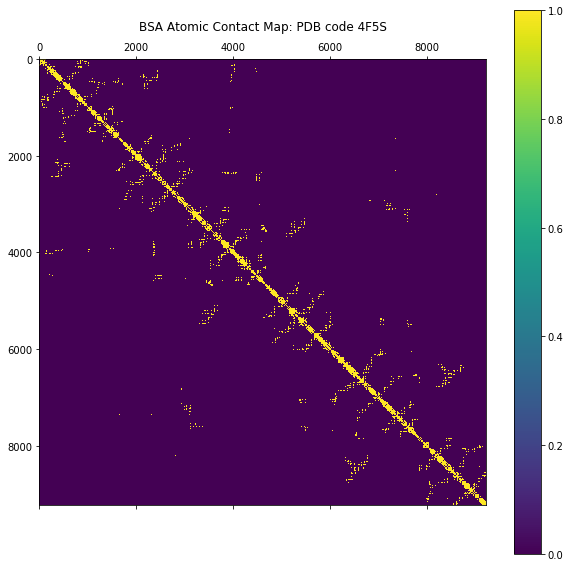

In [20]:
p = u_plga.select_atoms("protein").positions
g = u_plga.select_atoms("resname PLG").positions

#Length units in MD Analysis is Angstroms, Using 8.5 A cutoff to better visualize atomic contacts
bs = maa_dist.contact_matrix(p,cutoff=8.5,box=u_plga.dimensions)
fig, ax = plt.subplots(figsize=(10,10))
l_s = ax.matshow(bs.astype(int))
fig.colorbar(l_s, ax=ax)
ax.set_title('BSA Atomic Contact Map: PDB code 4F5S')

In [21]:
# This code calculates how many atoms are in each residue of BSA and stores it in a dictionary 

# When saving new keys and their associated values in a dictionary, make sure the key is not the 
# same as a key that has already been saved. The value that has been saved with the key will be erased and the newest
# value will be placed in the dictionary if trying to add new value with the same key into the dict

rb_atom = {}
for i in range(len(red_bsa)):
    count = 0     
    st_r = red_bsa[i]
    for line in open("../BSA.pdb",'r'):
        if st_r in line:
            count += 1
    rb_atom[st_r] = count

rb_atom

{' ASP     1 ': 14,
 ' THR     2 ': 14,
 ' HIS     3 ': 17,
 ' LYS     4 ': 22,
 ' SER     5 ': 11,
 ' GLU     6 ': 15,
 ' ILE     7 ': 19,
 ' ALA     8 ': 10,
 ' HIS     9 ': 17,
 ' ARG    10 ': 24,
 ' PHE    11 ': 20,
 ' LYS    12 ': 22,
 ' ASP    13 ': 12,
 ' LEU    14 ': 19,
 ' GLY    15 ': 7,
 ' GLU    16 ': 15,
 ' GLU    17 ': 15,
 ' HIS    18 ': 17,
 ' PHE    19 ': 20,
 ' LYS    20 ': 22,
 ' GLY    21 ': 7,
 ' LEU    22 ': 19,
 ' VAL    23 ': 16,
 ' LEU    24 ': 19,
 ' ILE    25 ': 19,
 ' ALA    26 ': 10,
 ' PHE    27 ': 20,
 ' SER    28 ': 11,
 ' GLN    29 ': 17,
 ' TYR    30 ': 21,
 ' LEU    31 ': 19,
 ' GLN    32 ': 17,
 ' GLN    33 ': 17,
 ' CYS    34 ': 11,
 ' PRO    35 ': 14,
 ' PHE    36 ': 20,
 ' ASP    37 ': 12,
 ' GLU    38 ': 15,
 ' HIS    39 ': 17,
 ' VAL    40 ': 16,
 ' LYS    41 ': 22,
 ' LEU    42 ': 19,
 ' VAL    43 ': 16,
 ' ASN    44 ': 14,
 ' GLU    45 ': 15,
 ' LEU    46 ': 19,
 ' THR    47 ': 14,
 ' GLU    48 ': 15,
 ' PHE    49 ': 20,
 ' ALA    50 ': 10,
 '

In [ ]:
pairs, dist_pb = mda.lib.distances.capped_distance(p,g,max_cutoff=4.0, box=u_plga.dimensions)

In [ ]:
dist_pb

In [ ]:
pairs

In [ ]:
### This code is for the 30 PLGA trimers and BSA in a pure water system 

# Select protein
bsa_res = u_plga.select_atoms("protein")

for ts in u_plga.trajectory:
    
    # Current atomic coordinates of BSA protein 
    br = u_plga.select_atoms("protein").positions
    
    # Current atomic coordinates of PLG residues 
    #a_plga = u_plga.select_atoms("resname PLG")
    
    # number of atoms in each PLG residue minus 1
    n = 47 
    
    # Number of trimers in simulation  
    n_olgs = 31
    
    #initialize numpy matrix to calculate COM PLGA coordinates 
    com_plg = np.zeros(shape=(31,3))
    
    #number of atoms in BSA protein plus 1
    n_bsa_at = len(br) + 1
    
    for i in range(bsa_res.n_residues):
        # calculate the COM position of each residue in BSA, require atom index range for each residue
        # insert saved list 
        
        
    # There are 31 PLGA trimers in the simulation 
    for i in range(n_oligs):
        
        # Calculate the center of mass of each separate PLGA trimer
        com_plg[i] = u_plga.atoms[n_bsa_at:n_bsa_at+n].center_of_mass()
        # change the index to the next separate PLGA trimer 
        n_bsa_at = n_bsa_at + n + 1
    
    #Calculation of distance matrix (Use capped_distance to give array of distances between contact pairs)
    dmat = maa_dist.distance_array(br,com_plg,u_plga.dimensions, result=np.zeros(shape=9220,31))
    
    # Save Protein residue and frame count in a dictionary 
    
    # Check frame count with VMD occ values 
  

#### Calculate the autocorrelation of a variable in time 